## Results of AutoAugment Training a Resnet-18 with a PPO Agent
### Objective
Three models were trained in parallel (RL-augmented, randomly augmented, no augmentation) to classify images from the CIFAR-10 dataset, choosing one out of ten classes. The goal was to (1) reproduce results using an similar approach and (2) add a baseline comparison - a model trained with random augmentation - to assess whether RL-augmented training truly strengthens generalization. For the sake of completeness, the model trained without any augmentation should serve as another baseline to evaluate the overall performance gain of augmentation.
### Description of DAC using RL
Dynamic algorithm configuration in essence means optimizing any algorithm (mostly DL) dynamically. Usually, that means optimize specific parameters on-the-fly during training. In this case, tuning the strategy of augmenting images that are fed into a CNN. This could involve cropping, flipping, mirroring or changing contrast. The RL agent should learn a policy during training, which augmentation strategies (the actions) out of a search space (which is the same as the baseline) are optimally so that the learner (the CNN) generalizes well on the validation set. This can be seen as a grey-box optimization problem, because the agent can see the training dynamics (instead of only seeing the result AFTER the learner was trained). Whether or not the computational expense are worth the result can only show in validating with the held-out set.

## Get files

In [1]:
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from main import METRICS_PATH, SEEDS

trainingmetrics_list = []
testmetrics_list = []
agentmetrics = []

loss_list_rl_model = []
loss_list_rand_model = []
loss_list_base_model = []

acc_list_rl_model = []
acc_list_rand_model = []
acc_list_base_model = []

test_rl = []
test_rand = []
test_base = []

for i, seed in enumerate(SEEDS):
    METRICS_FILENAME = f"data/metrics/final_metrics_seednr_{seed}.csv"
    TESTMETRICS_FILENAME = f"data/metrics/final_testmetrics_seednr_{seed}.csv"
    AGENTPOLICIES_FILENAME = f"data/metrics/agent_policies_seednr_{seed}.csv"
    
    try:
        # Get files
        trainingmetrics_df = pd.read_csv(METRICS_FILENAME)
        testmetrics_list.append(pd.read_csv(TESTMETRICS_FILENAME))
        agentmetrics.append(pd.read_csv(AGENTPOLICIES_FILENAME))
    except Exception as e:
        print(f"Files do not exist: {e}")

    # Convert to np arrays
    loss_rl = np.array(literal_eval(trainingmetrics_df['rl'][0]))
    loss_rand = np.array(literal_eval(trainingmetrics_df['random'][0]))
    loss_base = np.array(literal_eval(trainingmetrics_df['none'][0]))

    loss_list_rl_model.append(loss_rl)
    loss_list_rand_model.append(loss_rand)
    loss_list_base_model.append(loss_base)
    
    acc_rl = np.array(literal_eval(trainingmetrics_df['rl'][1]))
    acc_rand = np.array(literal_eval(trainingmetrics_df['random'][1]))
    acc_base = np.array(literal_eval(trainingmetrics_df['none'][1]))
    
    acc_list_rl_model.append(acc_rl)
    acc_list_rand_model.append(acc_rand)
    acc_list_base_model.append(acc_base)
    
    test_rl.append(testmetrics_list[i]['rl'][0])
    test_rand.append(testmetrics_list[i]['random'][0])
    test_base.append(testmetrics_list[i]['none'][0])

# Plots

## Training Loss (CE) over Epochs

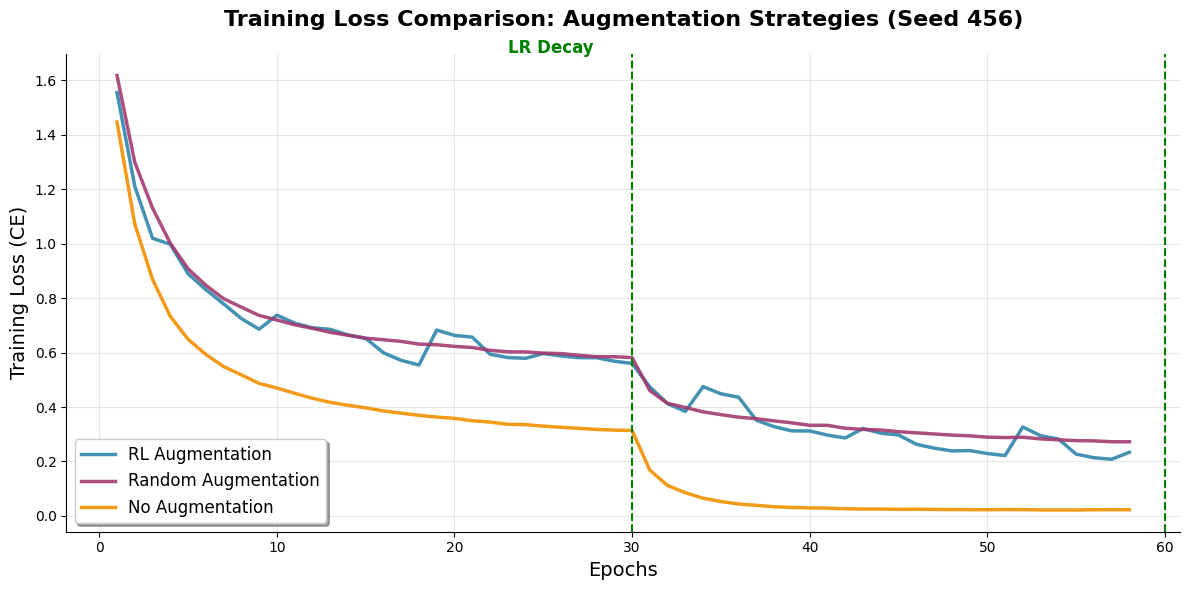

In [2]:
import matplotlib.pyplot as plt

avgResult_rl_list = []
avgResult_rand_list = []
avgResult_base_list = []

for i, seed in enumerate(SEEDS):
    n = loss_list_rl_model[i].reshape(-1, acc_list_rl_model[i].shape[0]).shape[0]
    avgResult_rl_list.append(np.average(loss_list_rl_model[i].reshape(-1, n), axis=1))
    avgResult_rand_list.append(np.average(loss_list_rand_model[i].reshape(-1, n), axis=1))
    avgResult_base_list.append(np.average(loss_list_base_model[i].reshape(-1, n), axis=1))

# Find minimum length across all models and seeds
min_length = min(
    min(len(avgResult_rl_list[i]) for i in range(len(SEEDS))),
    min(len(avgResult_rand_list[i]) for i in range(len(SEEDS))),
    min(len(avgResult_base_list[i]) for i in range(len(SEEDS)))
)

# Truncate all arrays to same length first
rl_truncated = [run[:min_length] for run in avgResult_rl_list]
rand_truncated = [run[:min_length] for run in avgResult_rand_list]
base_truncated = [run[:min_length] for run in avgResult_base_list]

# Now compute means and std devs
mean_rl = np.mean(rl_truncated, axis=0)
std_rl = np.std(rl_truncated, axis=0)
mean_rand = np.mean(rand_truncated, axis=0)
std_rand = np.std(rand_truncated, axis=0)
mean_base = np.mean(base_truncated, axis=0)
std_base = np.std(base_truncated, axis=0)

epochs = range(min_length)


plt.figure(figsize=(12, 6))
    
# Prepare data
epochs = range(1, len(mean_rl) + 1)

# Plot all three lines
plt.plot(epochs, mean_rl, label='RL Augmentation', 
            color='#2E86AB', linewidth=2.5, alpha=0.9)
plt.plot(epochs, mean_rand, label='Random Augmentation', 
            color='#A23B72', linewidth=2.5, alpha=0.9)
plt.plot(epochs, mean_base, label='No Augmentation', 
            color='#F18F01', linewidth=2.5, alpha=0.9)

# Styling
plt.title(f'Training Loss Comparison: Augmentation Strategies (Seed {seed})', 
            fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training Loss (CE)', fontsize=14)
plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add LR scheduler marker
ax.axvline(30, ls='--', c='g')
ax.axvline(60, ls='--', c='g')
ax.text(23,1.7, "LR Decay", fontsize=12, c='g', fontweight='bold')

plt.tight_layout()
plt.show()

## Agent Training

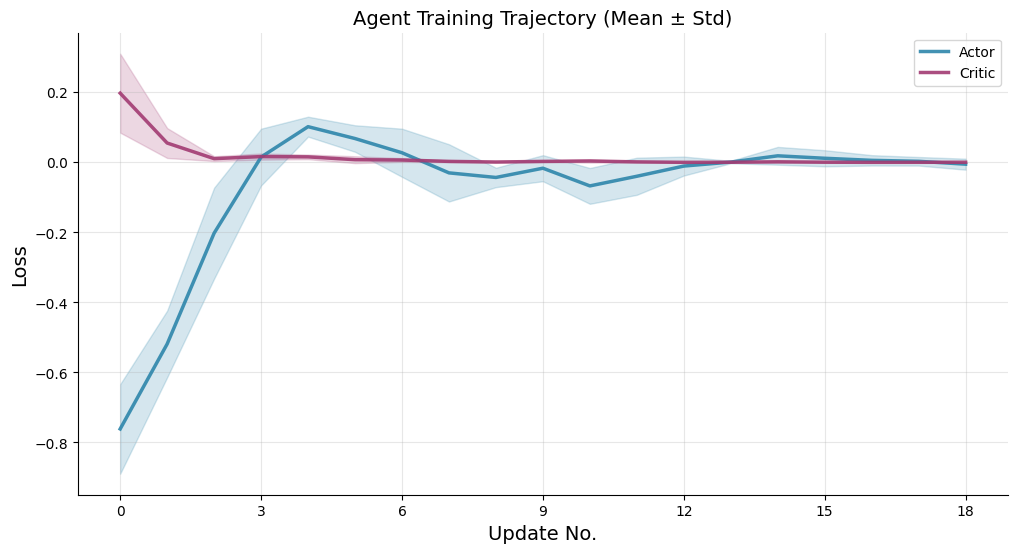

In [3]:
# Find minimum length across all seeds
min_length = min(len(losses['actor'].dropna()) for losses in agentmetrics)

# Collect truncated losses for all seeds
actor_losses = []
critic_losses = []

for i, losses in enumerate(agentmetrics):
    actor_losses.append(losses['actor'][:min_length])
    critic_losses.append(losses['critic'][:min_length])

# Compute means and std devs
mean_actor = np.mean(actor_losses, axis=0)
std_actor = np.std(actor_losses, axis=0)
mean_critic = np.mean(critic_losses, axis=0)
std_critic = np.std(critic_losses, axis=0)

plt.figure(figsize=(12, 6))

# Prepare data
updates = range(len(mean_actor))

# Plot mean lines with confidence bands
plt.plot(updates, mean_actor, color='#2E86AB', linewidth=2.5, alpha=0.9, label='Actor')
plt.fill_between(updates, mean_actor - std_actor, mean_actor + std_actor,
                 color='#2E86AB', alpha=0.2)

plt.plot(updates, mean_critic, color='#A23B72', linewidth=2.5, alpha=0.9, label='Critic')
plt.fill_between(updates, mean_critic - std_critic, mean_critic + std_critic,
                 color='#A23B72', alpha=0.2)

plt.xlabel("Update No.", fontsize=14)
plt.xticks(np.arange(0, len(mean_actor), len(mean_actor)//6))
plt.ylabel("Loss", fontsize=14)
plt.title("Agent Training Trajectory (Mean ± Std)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Agent policy

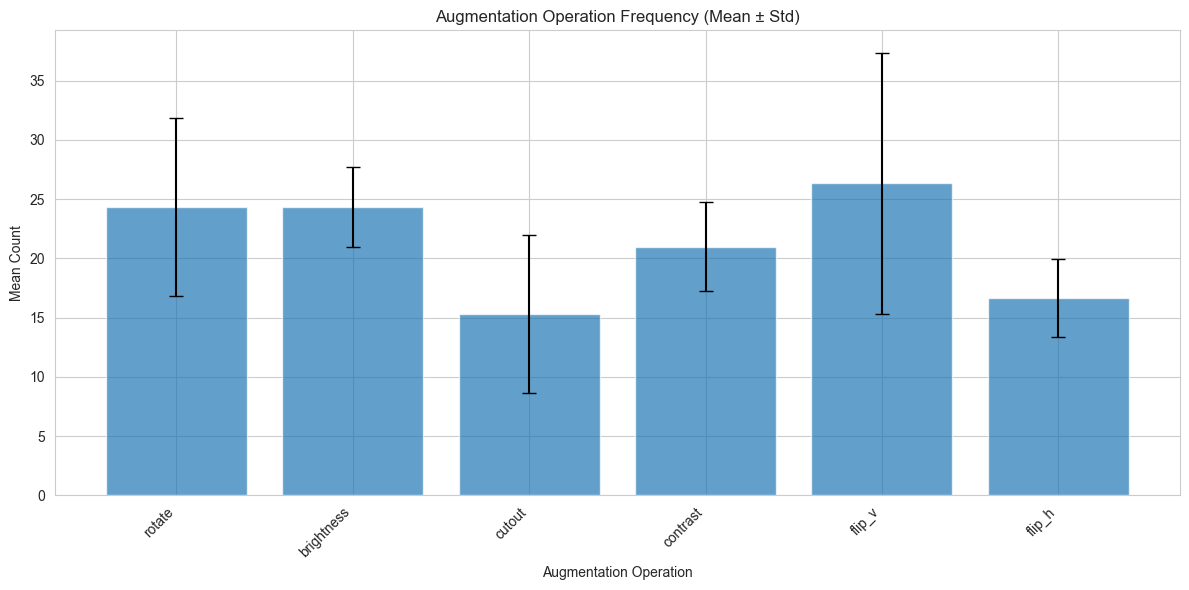

In [12]:
from augment import AugmentationSpace
from collections import defaultdict

space = AugmentationSpace() # For augmentation info extraction

# Dictionary to store counts for each operation across all seeds
all_op_counts = defaultdict(list)

# Get all possible operations from your search space
all_operations = set()

# First pass: collect all operations and their counts per seed
for i, seed in enumerate(SEEDS):
    op_list = []
    for policy in agentmetrics[i]['policy'].items():
        op_list.append(literal_eval(policy[1])['operation'])
    
    # Count operations for this seed
    op_dict = {space.operations[op]: 0 for op in set(op_list)}
    for operation in op_list:
        op_dict[space.operations[operation]] += 1
    
    # Add to our collection
    for op_name in op_dict:
        all_operations.add(op_name)
    
    # Store counts for each operation (0 if not present)
    for op in all_operations:
        if op in op_dict:
            all_op_counts[op].append(op_dict[op])

# Ensure all operations have counts for all seeds (fill with 0s if missing)
for op in all_operations:
    while len(all_op_counts[op]) < len(SEEDS):
        all_op_counts[op].append(0)

# Calculate mean and std for each operation
operations = list(all_operations)
means = [np.mean(all_op_counts[op]) for op in operations]
stds = [np.std(all_op_counts[op]) for op in operations]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(operations, means, yerr=stds, capsize=5, alpha=0.7)
plt.xlabel("Augmentation Operation")
plt.ylabel("Mean Count")
plt.title(f"Augmentation Operation Frequency (Mean ± Std)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Validation Accuracy over Epochs

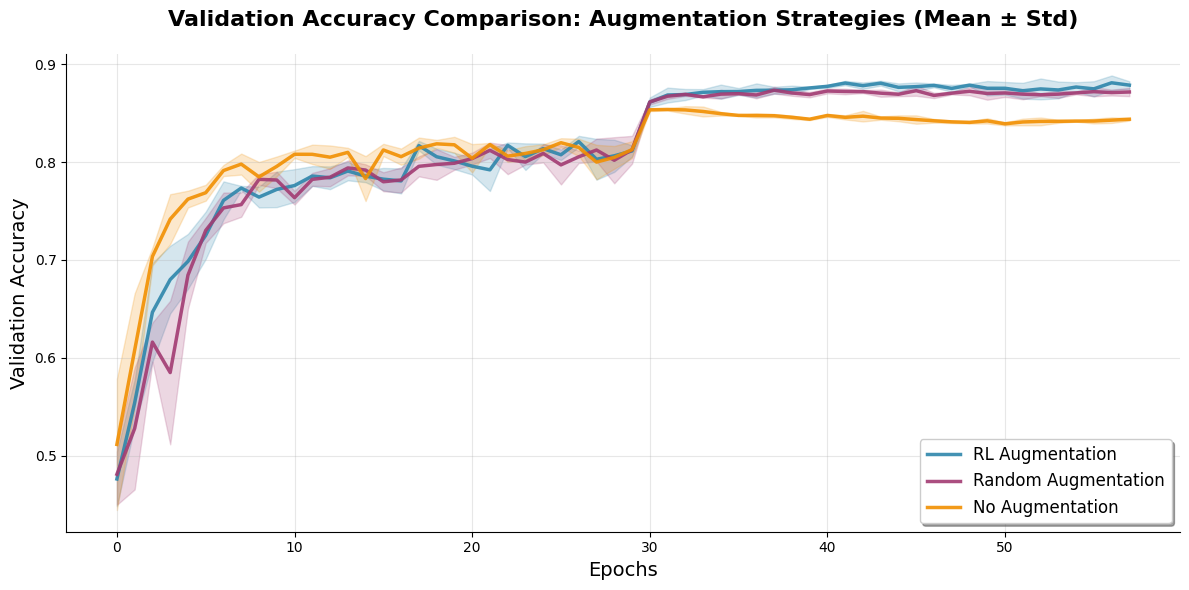

In [5]:
# Find minimum length across all models and seeds
min_length = min(
    min(len(run) for run in acc_list_rl_model),
    min(len(run) for run in acc_list_rand_model),
    min(len(run) for run in acc_list_base_model)
)

# Truncate all arrays to same length first
rl_truncated = [run[:min_length] for run in acc_list_rl_model]
rand_truncated = [run[:min_length] for run in acc_list_rand_model]
base_truncated = [run[:min_length] for run in acc_list_base_model]

# Now compute means and std devs
mean_rl = np.mean(rl_truncated, axis=0)
std_rl = np.std(rl_truncated, axis=0)
mean_rand = np.mean(rand_truncated, axis=0)
std_rand = np.std(rand_truncated, axis=0)
mean_base = np.mean(base_truncated, axis=0)
std_base = np.std(base_truncated, axis=0)

epochs = range(min_length)

# Rest of plotting code stays the same...

plt.figure(figsize=(12, 6))

# Plot mean lines with confidence bands
plt.plot(epochs, mean_rl, label='RL Augmentation', 
         color='#2E86AB', linewidth=2.5, alpha=0.9)
plt.fill_between(epochs, mean_rl - std_rl, mean_rl + std_rl, 
                 color='#2E86AB', alpha=0.2)

plt.plot(epochs, mean_rand, label='Random Augmentation',
         color='#A23B72', linewidth=2.5, alpha=0.9)
plt.fill_between(epochs, mean_rand - std_rand, mean_rand + std_rand,
                 color='#A23B72', alpha=0.2)

plt.plot(epochs, mean_base, label='No Augmentation',
         color='#F18F01', linewidth=2.5, alpha=0.9)
plt.fill_between(epochs, mean_base - std_base, mean_base + std_base,
                 color='#F18F01', alpha=0.2)

# Styling
plt.title('Validation Accuracy Comparison: Augmentation Strategies (Mean ± Std)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Test Accuracy

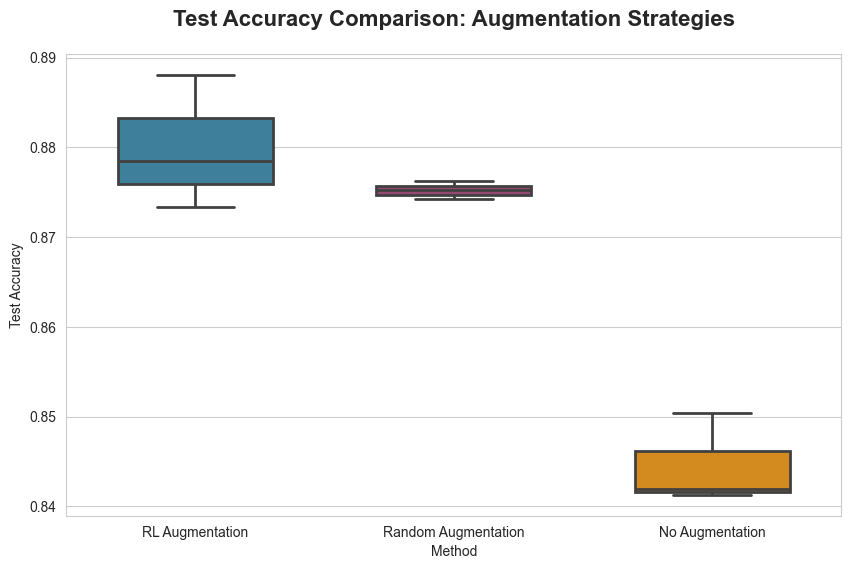

In [6]:
data = []
methods = ['RL Augmentation', 'Random Augmentation', 'No Augmentation']
results = [test_rl, test_rand, test_base]

for method, accuracies in zip(methods, results):
    for acc in accuracies:
        data.append({'Method': method, 'Test Accuracy': acc})

data_df = pd.DataFrame(data)

# Set style and create plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data_df, x='Method', y='Test Accuracy', palette=['#2E86AB', '#A23B72', '#F18F01'],
                    width=0.6, linewidth=2, hue='Method')
plt.title('Test Accuracy Comparison: Augmentation Strategies', 
            fontsize=16, fontweight='bold', pad=20)
plt.show()

## Extended Reward Function
Reward functions give a direct signal to the agent's learning behaviour. Using the validation accuracy as a reward signal is straightforward, yet it may wash out distributions over probabilistic components, like uncertainty or information gain. Therefore, we extended the reward function by using the entropy. In information theory, entropy can give insight about how much information can be provided by measuring the average level of uncertainty.

$ R(x) = Acc + \lambda \cdot H(x) $

In [7]:
agentmetrics = []
test_metrics = []

for seed in SEEDS:
    TESTMETRICS_FILENAME = f"data/metrics/final_testmetrics_seednr_{seed}_entropyreward_0.2.csv"
    AGENTPOLICIES_FILENAME = f"data/metrics/agent_policies_seednr_{seed}_entropyreward_0.2.csv"

    agentmetrics.append(pd.read_csv(AGENTPOLICIES_FILENAME))
    test_metrics.append(pd.read_csv(TESTMETRICS_FILENAME))

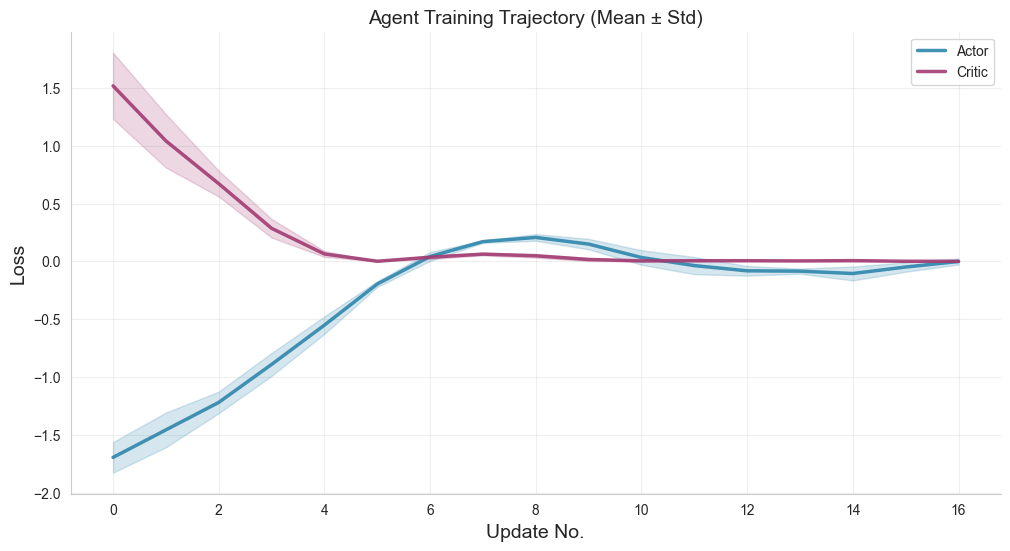

In [8]:
# Find minimum length across all seeds
min_length = min(len(losses['actor'].dropna()) for losses in agentmetrics)

# Collect truncated losses for all seeds
actor_losses = []
critic_losses = []

for i, losses in enumerate(agentmetrics):
    actor_losses.append(losses['actor'][:min_length])
    critic_losses.append(losses['critic'][:min_length])

# Compute means and std devs
mean_actor = np.mean(actor_losses, axis=0)
std_actor = np.std(actor_losses, axis=0)
mean_critic = np.mean(critic_losses, axis=0)
std_critic = np.std(critic_losses, axis=0)

plt.figure(figsize=(12, 6))

# Prepare data
updates = range(len(mean_actor))

# Plot mean lines with confidence bands
plt.plot(updates, mean_actor, color='#2E86AB', linewidth=2.5, alpha=0.9, label='Actor')
plt.fill_between(updates, mean_actor - std_actor, mean_actor + std_actor,
                 color='#2E86AB', alpha=0.2)

plt.plot(updates, mean_critic, color='#A23B72', linewidth=2.5, alpha=0.9, label='Critic')
plt.fill_between(updates, mean_critic - std_critic, mean_critic + std_critic,
                 color='#A23B72', alpha=0.2)

plt.xlabel("Update No.", fontsize=14)
plt.xticks(np.arange(0, len(mean_actor), len(mean_actor)//6))
plt.ylabel("Loss", fontsize=14)
plt.title("Agent Training Trajectory (Mean ± Std)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [9]:
test_metrics[0].iloc[0][1]

/tmp/ipykernel_22688/3824306298.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_metrics[0].iloc[0][1]


np.float64(0.8736)

/tmp/ipykernel_22688/3338745872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data_df, y='Test Accuracy', palette=['#2E86AB'],


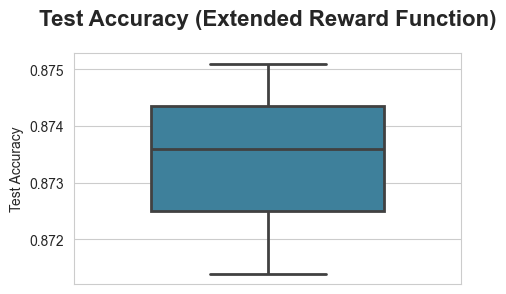

In [10]:
data = []
for metrics in test_metrics:
    data.append({'Test Accuracy': metrics.iloc[0].values[1]})

data_df = pd.DataFrame(data)

# Set style and create plot
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
ax = sns.boxplot(data_df, y='Test Accuracy', palette=['#2E86AB'],
                    width=0.6, linewidth=2)
plt.title('Test Accuracy (Extended Reward Function)', 
            fontsize=16, fontweight='bold', pad=20)
plt.show()

# Key Findings
- ## Training
- ## Evaluation
- ## Test